# Lab 10 : Multilayer Perceptron

## 1. Load the dataset

In [59]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
import pandas as pd


DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [60]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels


def get_X_Y(labels):
    # Get the images for each label
    img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    n_sample_per_class = 1000 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    X = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path, 0) #Load the gray image
            #Resizing
            img = cv2.resize(src=img, dsize=img_shape)
            #Normalization
            img = img/255
            #Add the image in the feature matrix and its labels to the label vector
            X[i*n_sample_per_class+j, :] = img.flatten()
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, Y

labels = get_labels()
X, Y = get_X_Y(labels)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)


Feature matrix : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


## 2. Dimension reduction with PCA

In [61]:
from sklearn.decomposition import PCA
from sklearn import set_config

In [62]:
set_config(display="diagram")
pca = PCA(n_components=90)
pca.fit_transform(X)
X_pca = pca.transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.25, random_state=42)

## 3. Use MLP to classify

In [64]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [65]:
def get_model(h_layers, X):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=X.shape[1]))
    for i in range(len(h_layers)):
        model.add(tf.keras.layers.Dense(units=h_layers[i], activation='relu'))
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=len(labels), activation='softmax'))
    return model

In [66]:
model = get_model([64], X_train)
model.compile(optimizer="adam", 
              loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

In [67]:
model.summary()

Model: "sequential_284"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_702 (Dense)           (None, 64)                5824      
                                                                 
 dropout_418 (Dropout)       (None, 64)                0         
                                                                 
 dense_703 (Dense)           (None, 9)                 585       
                                                                 
Total params: 6,409
Trainable params: 6,409
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
163/169 [===========================>..] - ETA: 0s - loss: 2.6326 - accuracy: 0.2692WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000186A9AC1168> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
169/169 [==============================] - 3s 8ms/step - loss: 2.6105 - accuracy: 0.2722 - val_loss: 1.4842 - val_accuracy: 0.4800
Epoch 2/5

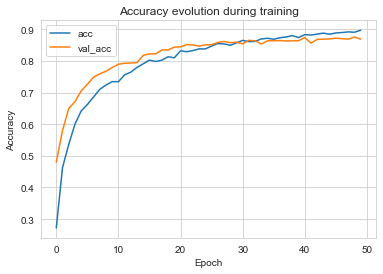

In [69]:
plt.figure()
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

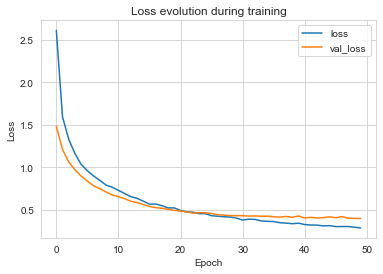

In [70]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss evolution during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training curves of the evolution of the accuracy and the loss during the training of the model shows the model performs well by reaching an accuracy near 90% for both training data and validation data. Moreover, the dynamic of the training and validation curves seems similar which seems to show the model is not overfiting.

## 4. Use cross-validation to test the model

In [71]:
def cross_val_split(X_pca, Y, k_fold=10):
    """
    Split the dataset in k fold to prepare a cross-validation
    :param X_pca: feature matrix
    :param Y: label vector
    :param k_fold: number of fold
    :return:
    """
    idx = np.arange(0, X_pca.shape[0])
    np.random.shuffle(idx)
    sample_per_fold = X_pca.shape[0]//k_fold
    X_fold_test = []
    X_fold_train = []
    Y_fold_test = []
    Y_fold_train = []
    for i in range(k_fold):
        if i==k_fold-1:
            idx_fold_i = idx[i*sample_per_fold:len(idx)]
            idx_train_i = idx[0:i*sample_per_fold]
        elif i==0:
            idx_fold_i = idx[0:sample_per_fold]
            idx_train_i = idx[i*sample_per_fold:(i+1)*sample_per_fold]
        else:
            idx_fold_i = idx[i*sample_per_fold:(i+1)*sample_per_fold]
            idx_train_i = np.concatenate((idx[0:i*sample_per_fold], idx[(i+1)*sample_per_fold:len(idx)]), axis=None)
        X_fold_test.append(X_pca[idx_fold_i, :])
        X_fold_train.append(X_pca[idx_train_i])
        Y_fold_test.append(Y[idx_fold_i])
        Y_fold_train.append(Y[idx_train_i])
    return X_fold_train, X_fold_test, Y_fold_train, Y_fold_test


In [72]:
def cross_val(X_pca, Y, h_layers, k_fold=10, epochs=50, batch_size=32, l_rate=0.001):
    """
    Cross validation
    :param X_pca:
    :param Y:
    :param h_layers:
    :param k_fold:
    :param epochs:
    :param batch_size:
    :param l_rate:
    :return:
    """
    X_fold_train, X_fold_test, Y_fold_train, Y_fold_test = cross_val_split(X_pca, Y, k_fold=k_fold)
    y_pred_fold = []
    acc = []
    for i in range(10):
        print('---'*10)
        print("k-fold {}".format(i))
        X_test_i = X_fold_test[i]
        Y_test_i = Y_fold_test[i]
        X_train_i = X_fold_train[i]
        Y_train_i = Y_fold_train[i]
        model = get_model(h_layers, X_train_i)
        opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
        model.compile(opt, loss='sparse_categorical_crossentropy', metrics='accuracy')
        model.fit(X_train_i, Y_train_i, epochs=epochs, batch_size=batch_size, verbose=0)

        pred_prob = model.predict(X_test_i)

        y_pred_i = np.argmax(pred_prob, axis=1)

        acc_i = len(np.where(y_pred_i==Y_test_i)[0])/len(Y_test_i)
        print('Test accuracy : {}'.format(acc_i))
        acc.append(acc_i)
        y_pred_fold.append(y_pred_i)
    return acc, y_pred_fold

In [73]:
acc, y_pred_fold = cross_val(X_pca, Y, h_layers=[64], k_fold=10, epochs=50, batch_size=32, l_rate=0.001)

------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 2ms/step
Test accuracy : 0.98
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

In [74]:
print('Accruracy : {} +- {}'.format(np.mean(acc), np.std(acc)))

Accruracy : 0.9026666666666667 +- 0.02627114081090071


## 5. Hyperparameters investigation

In [75]:
l_rates = [0.1, 0.01, 0.001, 0.001]
BATCH_SIZES = [8, 16, 32, 64]
h_layers = [[128], [64], [32]]

EPOCHS = 30

### Test the impact of the number of neurons in a model with one hidden layer:

To test the impact of the number of neurons in the first layer of the MLP, we fix all the other hyperparameters : $\alpha=0.001$ (learning rate), batch_size=32, epochs=30, ReLu activation function in hidden layers, softmax in the output layer with sparse categorical cross entropy.

In [76]:
history_h_layers_1 = {}
for i in range(len(h_layers)):
    print('CROSS VALIDATION with {} hidden layer'.format(h_layers[i]))
    acc, y_pred = cross_val(X_pca, Y, h_layers=h_layers[i], epochs=30)
    history_h_layers_1[h_layers[i][0]] = acc


CROSS VALIDATION with [128] hidden layer
------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 1ms/step
Test accuracy : 0.98
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obje

In [77]:
# Add test with 256 neurons in the first hidden layer
acc, y_pred = cross_val(X_pca, Y, h_layers=[256], epochs=30)
history_h_layers_1[256] = acc


------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 1ms/step
Test accuracy : 0.9988888888888889
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonl

In [78]:
# Add test with 512 neurons in the first hidden layer
acc, _ = cross_val(X_pca, Y, h_layers=[512], epochs=30)
history_h_layers_1[512] = acc

------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 2ms/step
Test accuracy : 1.0
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

In [79]:
# Add test with 1024 neurons in the first hidden layer
acc, _ = cross_val(X_pca, Y, h_layers=[1024], epochs=30)
history_h_layers_1[1024] = acc

------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 2ms/step
Test accuracy : 1.0
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

In [80]:
def fine_tune_plot(ax, history_kfold, title, xlabel, ylabel):
    ax.boxplot([history_kfold[key] for key in history_kfold.keys()], showfliers=False)
    ax.set_title(title)
    ax.set_xticks(np.arange(1, len(history_kfold.keys()) + 1))
    ax.set_xticklabels([key for key in history_kfold.keys()])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


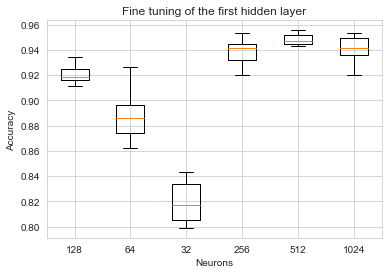

In [81]:
f, ax = plt.subplots(1)
fine_tune_plot(ax,history_h_layers_1, 'Fine tuning of the first hidden layer', 'Neurons', 'Accuracy')

This investigation seems to show that a MLP with one hidden layer and 64 neurons seems better than with fewer neurons. We can continue the investigation by adding other layers.

In [82]:
h_layers = [[512, 64], [512, 32], [512, 16]]
history_h_layers_2 = {}
for i in range(len(h_layers)):
    print('CROSS VALIDATION with {} hidden layer'.format(h_layers[i]))
    acc, y_pred = cross_val(X_pca, Y, h_layers=h_layers[i], epochs=30)
    history_h_layers_2[h_layers[i][1]] = acc


CROSS VALIDATION with [512, 64] hidden layer
------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 2ms/step
Test accuracy : 1.0
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' o

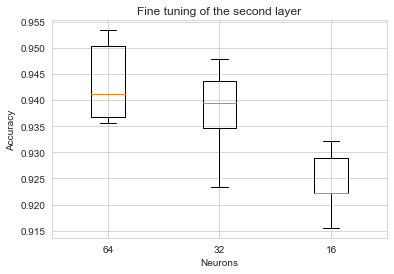

In [83]:
f, ax = plt.subplots(1)
fine_tune_plot(ax,history_h_layers_2, 'Fine tuning of the second layer', 'Neurons', 'Accuracy')

In [84]:
h_layers = [[512, 64, 64], [512, 64, 32], [512, 64, 16]]
history_h_layers_3 = {}
for i in range(len(h_layers)):
    print('CROSS VALIDATION with {} hidden layer'.format(h_layers[i]))
    acc, y_pred = cross_val(X_pca, Y, h_layers=h_layers[i], epochs=30)
    history_h_layers_3[h_layers[i][2]] = acc


CROSS VALIDATION with [512, 64, 64] hidden layer
------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 2ms/step
Test accuracy : 0.9933333333333333
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
C

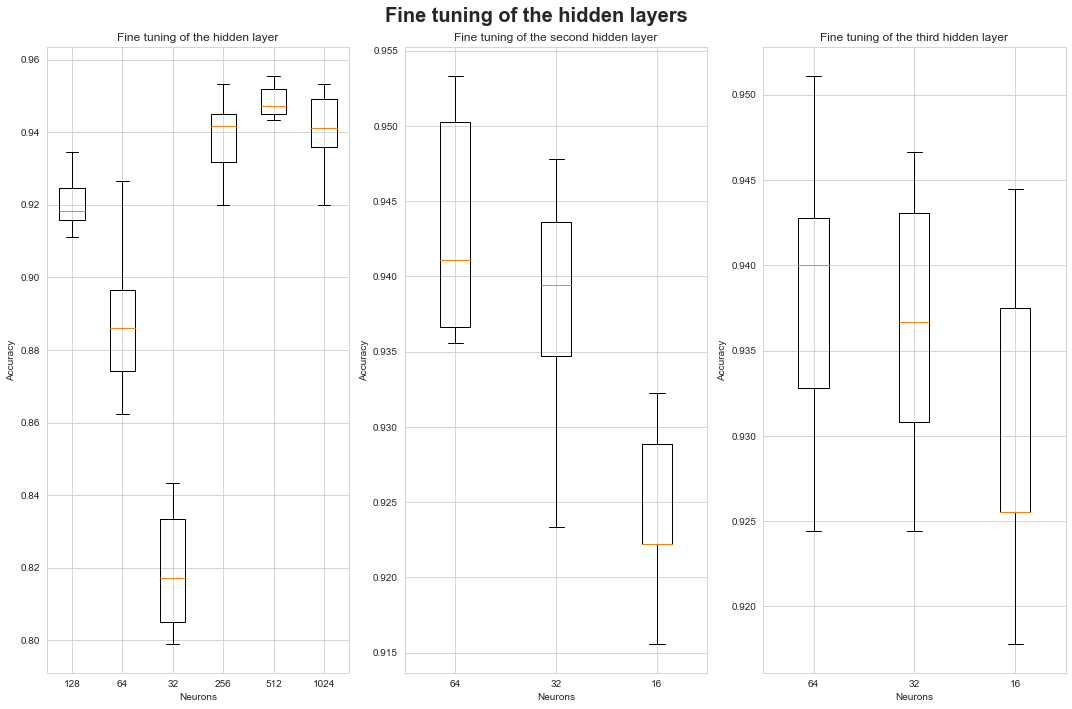

In [85]:

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
fig.suptitle('Fine tuning of the hidden layers', fontweight='bold', size=20)
fine_tune_plot(ax[0],history_h_layers_1, 'Fine tuning of the hidden layer', 'Neurons', 'Accuracy')
fine_tune_plot(ax[1],history_h_layers_2, 'Fine tuning of the second hidden layer', 'Neurons', 'Accuracy')
fine_tune_plot(ax[2],history_h_layers_3, 'Fine tuning of the third hidden layer', 'Neurons', 'Accuracy')
fig.tight_layout()

The architecture with one hidden layer with 64 neurons seems to be the best. We will keep this architecture to test the other hyperparameters.

### Fine-tuning of the learning rate:

In [86]:
history_l_rate = {}
for i in range(len(l_rates)):
    print('CROSS VALIDATION with l_rate={}'.format(l_rates[i]))
    acc, y_pred = cross_val(X_pca, Y, h_layers=[64], epochs=30, l_rate=l_rates[i])
    history_l_rate[l_rates[i]] = acc

CROSS VALIDATION with l_rate=0.1
------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 1ms/step
Test accuracy : 0.8677777777777778
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments

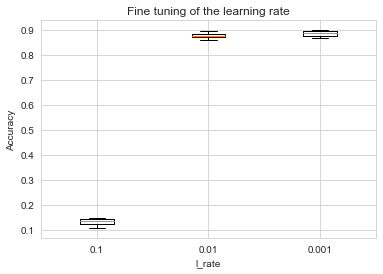

In [87]:
fig, ax = plt.subplots(1)
fine_tune_plot(ax,history_l_rate, 'Fine tuning of the learning rate', 'l_rate', 'Accuracy')

### Fine-tuning of the batch-size:

In [88]:
history_batch_size = {}
for i in range(len(h_layers)):
    print('CROSS VALIDATION with batch_size={}'.format(BATCH_SIZES[i]))
    acc, y_pred = cross_val(X_pca, Y, h_layers=[64], epochs=30, batch_size=BATCH_SIZES[i])
    history_batch_size[BATCH_SIZES[i]] = acc

CROSS VALIDATION with batch_size=8
------------------------------
k-fold 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
29/29 [==============================] - 0s 1ms/step
Test accuracy : 0.99
------------------------------
k-fold 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has

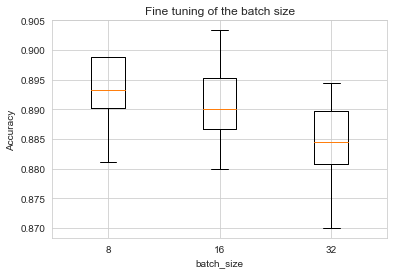

In [89]:
fig, ax = plt.subplots(1)
fine_tune_plot(ax, history_batch_size, 'Fine tuning of the batch size', 'batch_size', 'Accuracy')

# Scikit Grid Search

In [101]:
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier

a_classifier = get_model([512], X_train)
a_classifier.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    metrics=["accuracy"])

b_classifier = get_model([512], X_train)
b_classifier.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=["accuracy"])

c_classifier = get_model([512, 64], X_train)
c_classifier.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    metrics=["accuracy"])

d_classifier = get_model([512, 64], X_train)
d_classifier.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics=["accuracy"])

a_pipe = Pipeline(steps=[('nn', KerasClassifier(a_classifier, verbose=0))])
b_pipe = Pipeline(steps=[('nn', KerasClassifier(b_classifier, verbose=0))])
c_pipe = Pipeline(steps=[('nn', KerasClassifier(c_classifier, verbose=0))])
d_pipe = Pipeline(steps=[('nn', KerasClassifier(d_classifier, verbose=0))])

params_grid = {
    'nn__batch_size' : [8],
    'nn__epochs' : [50]
}

In [102]:
def run_grid_search(pipeline, params):
    search = GridSearchCV(estimator=pipeline, param_grid=params, scoring='accuracy', cv=10)
    search.fit(X_train, y_train)
    #search.score(X_train, y_train)
    print("Best params found : ", search.best_params_)
    print("Score : ", round(search.score(X_test, y_test), 3))
    return search


In [103]:
a_search = run_grid_search(a_pipe, params_grid)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [104]:
b_search = run_grid_search(b_pipe, params_grid)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [105]:
c_search = run_grid_search(c_pipe, params_grid)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [106]:
d_search = run_grid_search(d_pipe, params_grid)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [107]:
model_list = [(a_pipe, a_search, r'HL:[512], $\alpha=0.01$'), (b_pipe, b_search, r'HL:[512], $\alpha=0.001$'), (c_pipe, c_search, r'HL:[512, 64], $\alpha=0.01$'), (d_pipe, d_search, r'HL:[512, 64], $\alpha=0.001$')]

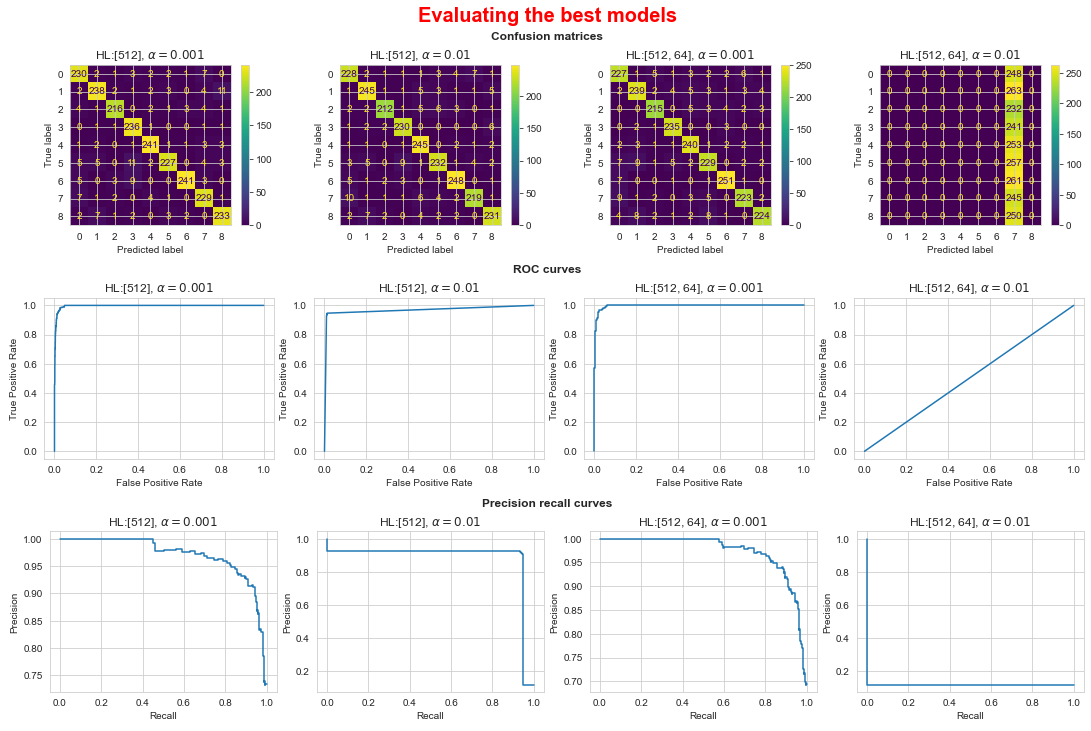

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, \
    precision_recall_curve, PrecisionRecallDisplay, roc_auc_score


def get_best_grids(grids, amount=4):
    """
    Sort the grids regarding their test score
    """
    return sorted(grids, key=lambda model_tuple: model_tuple[1].score(X_test,y_test), reverse=True)[:amount]

# Create tuples for the grid : the grid object, prediction of the grid on the test data, probabilities predictions on test data and the name of the used model
best_grids = get_best_grids(model_list)
grid_tuples = []

for pipe, grid, name in best_grids:
    grid_tuples.append((grid, grid.predict(X_test), grid.predict_proba(X_test), name))


def compute_cf_metrics(cm, grid_tuple):
    """
    Compute the metrics (FP, TP, TN, FN, TP, Sensitivity, Specificity, Precision, Recall, Accuracy and AUC) given a confusion matrix
    """
    metrics = {}

    # Compute the FP, FN, TP, TN metrics from the confusion matrix
    FP = (cm.sum(axis=0) - np.diag(cm))
    FN = (cm.sum(axis=1) - np.diag(cm))
    accuracy = np.diag(cm)/cm.sum(axis=0)
    TP = np.diag(cm)
    TN = (cm.sum() - (FP + FN + TP))

    # Save the value in the metrics dictionary
    metrics['FP'] = FP
    metrics['TP'] = TP
    metrics['TN'] = TN
    metrics['FN'] = FN
    metrics['TP'] = TP

    # Sensitivity, hit rate, recall, or true positive rate
    metrics['Sensitivity'] = TP/(TP+FN)
    # Specificity or true negative rate
    metrics['Specificity'] = TN/(TN+FP)
    # Precision or positive predictive value
    metrics['Precision'] = TP/(TP+FP)
    # Recall
    metrics['Recall'] = TP / (TP+FN)
    # Accuracy
    metrics['Accuracy'] = accuracy
    metrics['AUC'] = roc_auc_score(y_test, grid_tuple[2], multi_class='ovr')
    return metrics


def plot_confusion_matrices(axs, grid_tuples):
    cm_list = []
    for i, grid_tuple in enumerate(grid_tuples):
        cm = confusion_matrix(y_test, grid_tuple[1])
        cm_display = ConfusionMatrixDisplay(cm)
        cm_display.plot(ax=axs[i])
        cm_display.ax_.set_title(grid_tuple[-1])
        cm_list.append(cm)
    return cm_list

def display_metrics(cm_list, grid_tuples):
    """
    Display the metrics in a table and plot two histograms to compare the metrics of different models
    :param cm_list: list of confusion matrix of each model
    :param grid_tuples: list of each grid tuple
    :return:
    """
    metrics_df = [] #List of dataframe of averaged computed metrics for each model
    for i in range(len(cm_list)):
        cm_metrics = compute_cf_metrics(cm_list[i], grid_tuples[i])
        df = pd.DataFrame(cm_metrics).transpose()
        mean_metrics = pd.DataFrame(df.mean(axis=1))
        metrics_df.append(mean_metrics)
    #Create a DataFrame with all the results
    metrics_name = metrics_df[-1].index
    metrics_data = [metric_rep.values[:,0] for metric_rep in metrics_df]
    metrics_per_model = pd.DataFrame(metrics_data).T
    metrics_per_model.columns = [grid_tuple[-1] for grid_tuple in grid_tuples]
    metrics_per_model.index = metrics_name

    display_1_df = pd.DataFrame([metrics_per_model.T.FP, metrics_per_model.T.TP,  metrics_per_model.T.TN,  metrics_per_model.T.FN])
    display_2_df = pd.DataFrame([metrics_per_model.T.Sensitivity, metrics_per_model.T.Specificity,  metrics_per_model.T.Precision,  metrics_per_model.T.Recall, metrics_per_model.T.Accuracy, metrics_per_model.T.AUC])

    # Plot the histogram of the averaged metrics for each models
    display_1_df.plot.bar()
    plt.title('MLP Models evaluation (1/2)')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    display_2_df.plot.bar()
    plt.title('MLP Models evaluation (2/2)')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    return metrics_per_model


def plot_roc_curves(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        fpr, tpr, thresholds = roc_curve(y_test, grid_tuple[2][:, 1], pos_label=1)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(ax=axs[i])
        roc_display.ax_.set_title(grid_tuple[-1])

def plot_precision_recall_curves(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        prec, recall, thresholds = precision_recall_curve(y_test, grid_tuple[2][:, 1], pos_label=1)
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
        pr_display.plot(ax=axs[i])
        pr_display.ax_.set_title(grid_tuple[-1])


subfigures_titles = ['Confusion matrices', 'ROC curves', 'Precision recall curves']
subplot_funcs = [plot_confusion_matrices, plot_roc_curves, plot_precision_recall_curves]
cm_list = []

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
fig.suptitle('Evaluating the best models', fontweight='bold', size=20, color='red')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigures_titles[row], fontweight='semibold')

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=4)
    if row==0:
        cm_list = subplot_funcs[row](axs, grid_tuples)
    else:
        subplot_funcs[row](axs, grid_tuples)

C:\Users\rapha\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rapha\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


,FP,TP,TN,FN,Sensitivity,Specificity,Precision,Recall,Accuracy,AUC
"HL:[512], $\alpha=0.001$",17.666667,232.333333,1982.333333,17.666667,0.929839,0.991171,0.930107,0.929839,0.930107,0.996952
"HL:[512], $\alpha=0.01$",17.777778,232.222222,1982.222222,17.777778,0.928693,0.991105,0.929503,0.928693,0.929503,0.969501
"HL:[512, 64], $\alpha=0.001$",18.555556,231.444444,1981.444444,18.555556,0.925939,0.990717,0.926200,0.925939,0.926200,0.996650
"HL:[512, 64], $\alpha=0.01$",222.777778,27.222222,1777.222222,222.777778,0.111111,0.888889,0.108889,0.111111,0.108889,0.500000


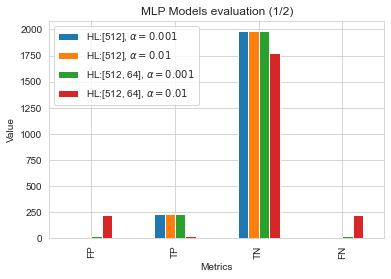

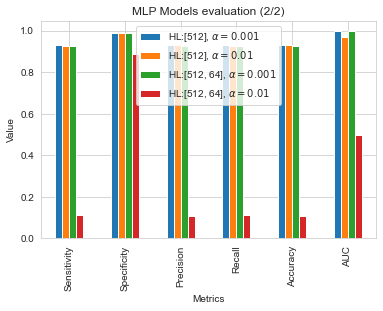

In [109]:
metric_df = display_metrics(cm_list, grid_tuples)
metric_df.T